# **ADSP - P8 PROJECT** - scientific papers classifier based on NLP
---
**CANDIDATES**

GILLIO FRANCESCO

SEMINARIO YRIGOYEN CESAR AUGUSTO

**COURSE** Applied Data Science Project

**University** Politecnico di Torino - Italy


## Project description

**BertTopic** is used to create a semi-supervised model with labels available

**Dataset** can be downloaded fro hugginface at the link: [Wiki Medical Terms](https://huggingface.co/datasets/gamino/wiki_medical_terms)

 ## <span style="font-family:Verdana; color:blue">  0. TO DO

<span style="font-family:Verdana; color:blue">

- download similar dataset from hugging-face to start practicing
- data cleaning
- create embeddings
- export embeddings
- start with the model
***

## 1. Exploring the dataset

In [1]:
%%capture
!pip install bertopic
!pip install datasets
!pip install openai

In [2]:
from datasets import load_dataset
import tqdm as notebook_tqdm
import pandas as pd

dataset = load_dataset("dhiruHF/research_paper_multi_label_data_balanced")
terms_number= len(dataset['train'])
print(f"N° wiki terms: {terms_number}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/382 [00:00<?, ?B/s]

(…)-00000-of-00001-6cb8c751614cff33.parquet:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1985 [00:00<?, ? examples/s]

N° wiki terms: 1985


In [3]:
def get_chapters(text):
    chapters = text.split('###')[2]
    labels = text.split('###')[3]
    labels = labels.split(':')[1]
    title=chapters.split('\n')[2].split(':')[1]
    abstract=chapters.split('\n')[3:]
    abstract[0]=abstract[0][9:]
    delimiter="\n"
    abstract=delimiter.join(abstract)
    #labels=labels.split(',')
    #labels=[label.strip() for label in labels]
    item_dict={}
    item_dict['title']=title
    item_dict['abstract']=abstract
    item_dict['labels']=labels
    return item_dict


In [41]:
item=get_chapters(dataset['train'][0]['text'])
print(item['title'])

 Reconstructing Subject-Specific Effect Maps


In [26]:
dataset['train'][0]['text'].split('###')[2]

"RESEARCH PAPER:\n\nTitle: Reconstructing Subject-Specific Effect Maps\nAbstract:   Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrap

In [4]:
#converting in structure dict:{title,abstract,labels}
data_dict=[get_chapters(item) for item in dataset['train']['text']]

In [5]:
item=1345
print(f"title:\n {data_dict[item]['title']}")
print(f"abstract:\n {data_dict[item]['abstract']}")
print(f"labels:\n {data_dict[item]['labels']}")

title:
  Bounds on the expected size of the maximum agreement subtree for a given tree shape
abstract:
    We show that the expected size of the maximum agreement subtree of two
$n$-leaf trees, uniformly random among all trees with the shape, is
$\Theta(\sqrt{n})$. To derive the lower bound, we prove a global structural
result on a decomposition of rooted binary trees into subgroups of leaves
called blobs. To obtain the upper bound, we generalize a first moment argument
for random tree distributions that are exchangeable and not necessarily
sampling consistent.



labels:
  ['Quantitative Biology']


<Axes: xlabel='labels'>

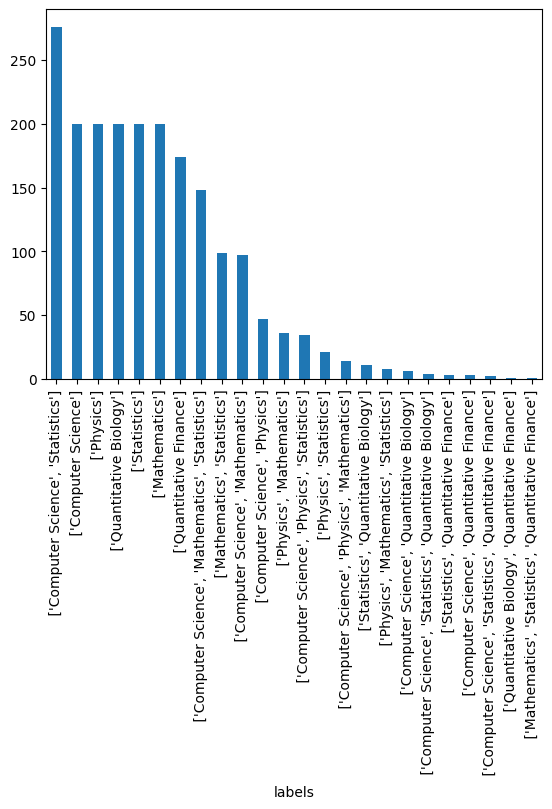

In [6]:
data_df= pd.DataFrame(data_dict)
data_df['labels'].value_counts().plot(kind='bar')

## 2. Preparing the dataset for BERTopic architecture

In [7]:
# functions preparing the dataset for BERTopic architecture

#1. Removing duplicates
print(f"initial size: {data_df.shape}")
data_df_clean=data_df.drop_duplicates(subset=['title'], keep ='first')
print(f"new size of items after removing duplicates: {data_df_clean.shape}")


initial size: (1985, 3)
new size of items after removing duplicates: (1985, 3)


In [8]:
#2. Removing nan or empty sign & symptomps terms
data_df_clean=data_df_clean[data_df_clean['title'].astype(bool)]
data_df_clean=data_df_clean[data_df_clean['abstract'].astype(bool)]
print(f"new size of items after removing na or empty title/abstract sections {data_df_clean.shape}")


new size of items after removing na or empty title/abstract sections (1985, 3)


## 3. Setting up base BERTopic model

### 3.1 Precalculate embeddings


In [9]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
title_embeddings = embedding_model.encode(data_df['title'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [11]:
abstract_embeddings = embedding_model.encode(data_df['abstract'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [12]:
# saving data
import numpy as np
np.save('title_embeddings.npy', title_embeddings)
np.save('abstract_embeddings.npy', abstract_embeddings)

In [13]:
data_df_clean.to_pickle('data_df_clean.pkl')

### 3.2 Setting up bertopic blocks

In [ ]:
#!pip install 'umap-learn==0.3.10'
from umap import UMAP
umap_model = UMAP(n_neighbors=20, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [ ]:
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
additional_stopwords=['Signs','signs','Sign', 'sign', 'Symptoms','symptoms','Symptom','symptom','include','affected','people','features','patients','disease','present','common','usually'] #'syndrome', disease, patient, patients
stop_words_mod=list(text.ENGLISH_STOP_WORDS)+additional_stopwords
vectorizer_model = CountVectorizer(stop_words=stop_words_mod, min_df=1, ngram_range=(1, 2))
# vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

### 3.3 DEFINING representation models

In [ ]:
#!pip install typing-extensions --upgrade

import openai
import bertopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
#from spacy import parts_of_speech
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
#pos_model = PartOfSpeech("en_core_web_sm")
# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# GPT-3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
client = openai.OpenAI(api_key="sk-...")
#openai_model = OpenAI(client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    # "OpenAI": openai_model,  # Uncomment if you will use OpenAI
    "MMR": mmr_model,
    #"POS": pos_model
}

## 4. Model exploration

### Tests:
HDBSCAN - choose reasonable number of topics


Vectorizer tests
- mindf=1 : changes just group 12: war--- to veteran.sle, war, gulf. # of topics are the same. SLe is the most representative doc, it's autoimmune disease


In [ ]:
from bertopic import BERTopic
from sklearn.cluster import KMeans
#put here the block to study in order to understand behaviors
# list_to_check=range(20,160,10)
list_to_check=[(1,3)]

params=[]
# list_to_check=range(140,160,10)
for size in list_to_check:#reversed(list_to_check):
  # hdbscan_model = HDBSCAN(min_cluster_size=size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
  vectorizer_model = CountVectorizer(stop_words=stop_words_mod, min_df=1, ngram_range=size)
  # hdbscan_model= KMeans(n_clusters=size)
  topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)
  topics, probs = topic_model.fit_transform(symtomps_as_paragraph, embeddings)
  print(f"size {size} analyzed")
  a=topic_model.get_topic_freq()
  # a['index_old']=a.index
  b=topic_model.get_topic_info()['Name']
  a.reset_index(inplace=True)
  b.reset_index(drop=True)
  a=pd.concat([a,b],axis=1)
  params.append(a)
  topic_model.get_topic_info()

2024-02-18 22:59:19,437 - BERTopic - Reduced dimensionality
2024-02-18 22:59:19,504 - BERTopic - Clustered reduced embeddings


size (1, 3) analyzed


In [ ]:
topic_model.get_topic_info()
# params[13].head()

In [ ]:
topic_model.get_representative_docs(15)

### saving model

In [ ]:
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save("./model_dir/hdbscan", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

### Accuracy Calculation
- find metrics - remember ICD11 per clustering

#### OPEC evaluation

In [ ]:
#creating dataset ready for opec



### Creating plots

In [ ]:
%matplotlib inline


### Model visualization: topics and documents

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
# Documents
from umap import UMAP
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
# Visualize the documents in 2-dimensional space and show the titles on hover instead of the abstracts
# NOTE: You can hide the hover with `hide_document_hover=True` which is especially helpful if you have a large dataset
labels=md_terms_ss_df['medical_term'].to_list()
topic_model.visualize_documents(labels, reduced_embeddings=reduced_embeddings)